# Climate-Related Development Finance (CRDF) Analysis

This notebook analyzes climate finance data from 2000-2023 with the following visualizations:

1. Climate Finance Over Time (Trend)
2. Top Recipient Countries (Distribution)
3. Finance by Region (Stacked Bar)
4. Adaptation vs Mitigation Balance
5. Distribution by Income Group (Equity)
6. Sector Allocation of Climate Finance
7. Provider → Recipient Network (Flows)
8. Project-Level Impact Proxy
9. Channel of Delivery Analysis

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Load the CRDF dataset
file_path = 'crdfdata.xlsx'

# First, check what sheets are available
xl_file = pd.ExcelFile(file_path)
print("Available sheets:", xl_file.sheet_names)

# Try reading the first sheet - the file might have headers in row 0
df = pd.read_excel(file_path, sheet_name=0, header=0)

# If empty, try reading without header to see what's there
if df.empty or len(df.columns) == 0:
    print("\nDataset appears empty. Trying to read without header to inspect...")
    df_temp = pd.read_excel(file_path, sheet_name=0, header=None, nrows=20)
    print("First 20 rows (no header):")
    print(df_temp)
    
    # Try to find the header row
    for i in range(min(10, len(df_temp))):
        row = df_temp.iloc[i]
        # Check if this row contains expected column names
        row_str = ' '.join([str(x).lower() for x in row.values if pd.notna(x)])
        if 'year' in row_str and 'recipient' in row_str:
            print(f"\nFound potential header row at index {i}")
            df = pd.read_excel(file_path, sheet_name=0, header=i)
            break

# If still empty, try other sheets
if (df.empty or len(df.columns) == 0) and len(xl_file.sheet_names) > 1:
    print(f"\nTrying other sheets...")
    for sheet in xl_file.sheet_names[1:]:
        print(f"Trying sheet: {sheet}")
        df = pd.read_excel(file_path, sheet_name=sheet, header=0)
        if not df.empty and len(df.columns) > 0:
            print(f"Successfully loaded from sheet: {sheet}")
            break

print(f"\nDataset shape: {df.shape}")
print(f"\nColumn names:")
if len(df.columns) > 0:
    print(df.columns.tolist()[:20])  # Show first 20 columns
    print(f"\nFirst few rows:")
    print(df.head())
else:
    print("No columns found. Please check the Excel file structure.")

Available sheets: ['All']

Dataset shape: (222723, 38)

Column names:
['Year', 'Provider Type', 'Provider', 'Provider (detailed)', 'Provider Code', 'Agency Code', 'Extending Agency', 'CRS Identification N°', 'Donor project N°', 'Recipient', 'Recipient Code', 'Recipient Region', 'Recipient Income Group (OECD Classification)', 'Concessionality', 'Climate objective (applies to Rio-marked data only) or climate component', 'Adaptation objective (applies to Rio-marked data only)', 'Mitigation objective (applies to Rio-marked data only)', 'Adaptation-related development finance (includes overlap) - Commitment - Current USD thousand', 'Adaptation-related development finance (includes overlap) - Commitment - 2023 USD thousand', 'Mitigation-related development finance (includes overlap) - Commitment - Current USD thousand']

First few rows:
   Year Provider Type   Provider Provider (detailed)  Provider Code  \
0  2000    DAC member    Finland             Finland             18   
1  2000    DAC 

In [3]:
# Explore the data structure
print("Data info:")
print(df.info())
print("\n\nMissing values:")
print(df.isnull().sum())
print("\n\nSample data:")
df.head(10)

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222723 entries, 0 to 222722
Data columns (total 38 columns):
 #   Column                                                                                         Non-Null Count   Dtype  
---  ------                                                                                         --------------   -----  
 0   Year                                                                                           222723 non-null  int64  
 1   Provider Type                                                                                  222723 non-null  object 
 2   Provider                                                                                       222723 non-null  object 
 3   Provider (detailed)                                                                            222723 non-null  object 
 4   Provider Code                                                                                  222723 non-null  int64  
 5 

,Year,Provider Type,Provider,Provider (detailed),Provider Code,Agency Code,Extending Agency,CRS Identification N°,Donor project N°,Recipient,Recipient Code,Recipient Region,Recipient Income Group (OECD Classification),Concessionality,Climate objective (applies to Rio-marked data only) or climate component,Adaptation objective (applies to Rio-marked data only),Mitigation objective (applies to Rio-marked data only),Adaptation-related development finance (includes overlap) - Commitment - Current USD thousand,Adaptation-related development finance (includes overlap) - Commitment - 2023 USD thousand,Mitigation-related development finance (includes overlap) - Commitment - Current USD thousand,Mitigation-related development finance (includes overlap) - Commitment - 2023 USD thousand,Overlap - Commitment - Current USD thousand,Overlap - Commitment - 2023 USD thousand,Climate-related development finance - Commitment - Current USD thousand,Climate-related development finance - Commitment - 2023 USD thousand,Channel of Delivery Code,Channel of Delivery,Purpose Code,Sector,Sub-sector,Development Cooperation Modality,Financial Instrument,Type of Finance,Project Title,Description,Coal-related Financing,"Share of the underlying commitment, % (when available)",Gender
0,2000,DAC member,Finland,Finland,18,3.0,Ministry of Foreign Affairs,1999003043z,48902201,"South America, regional",489,South America,Unallocated,Concessional and developmental,Significant,Not targeted/Not screened,Significant,0.0,0.0,542.492676,982.308692,0.0,0.0,542.492676,982.308692,NaN,NaN,31210.0,"III.1. Agriculture, Forestry, Fishing",Forestry policy and administrative management,NaN,Grant,110.0,"SUPPORT TO SUSTAINABLE FORESTRY, AMAZON",NaN,0.0,1.0,Significant
1,2000,DAC member,Finland,Finland,18,3.0,Ministry of Foreign Affairs,1997003038z,28700301,Burkina Faso,287,South of Sahara,LDCs,Concessional and developmental,Significant,Not targeted/Not screened,Significant,0.0,0.0,141.048096,255.400260,0.0,0.0,141.048096,255.400260,NaN,NaN,31220.0,"III.1. Agriculture, Forestry, Fishing",Forestry development,NaN,Grant,110.0,TO PREVENT FOREST FIRES AND EROSION,NaN,0.0,1.0,Not targeted
2,2000,DAC member,Australia,Australia,801,5.0,Australian Government,1999008264z,958H13,Vanuatu,854,Oceania,LMICs,Concessional and developmental,Significant,Not targeted/Not screened,Significant,0.0,0.0,11.004923,25.736735,0.0,0.0,11.004923,25.736735,NaN,NaN,31210.0,"III.1. Agriculture, Forestry, Fishing",Forestry policy and administrative management,NaN,Grant,110.0,VANUATU SUSTAINABLE FOREST UTILISATION,NaN,0.0,1.0,NaN
3,2000,DAC member,Australia,Australia,801,5.0,Australian Government,1999001653z,996K07,Sri Lanka,640,South & Central Asia,LMICs,Concessional and developmental,Significant,Not targeted/Not screened,Significant,0.0,0.0,17.376195,40.636950,0.0,0.0,17.376195,40.636950,NaN,NaN,31220.0,"III.1. Agriculture, Forestry, Fishing",Forestry development,NaN,Grant,110.0,NATURAL RESOURCE MANAGEMENT FEAS./DESIGN,NaN,0.0,1.0,NaN
4,2000,DAC member,Australia,Australia,801,5.0,Australian Government,1999001656z,996K03,Sri Lanka,640,South & Central Asia,LMICs,Concessional and developmental,Significant,Not targeted/Not screened,Significant,0.0,0.0,6.028370,14.098286,0.0,0.0,6.028370,14.098286,NaN,NaN,31181.0,"III.1. Agriculture, Forestry, Fishing",Agricultural education/training,NaN,Grant,110.0,AGRIC. EDUC.: FORESTRY PROJECT PREPARATION STU...,NaN,0.0,1.0,NaN
5,2000,DAC member,Australia,Australia,801,5.0,Australian Government,1998001087z,988K1C,Tonga,870,Oceania,UMICs,Concessional and developmental,Significant,Not targeted/Not screened,Significant,0.0,0.0,2323.930495,5434.875152,0.0,0.0,2323.930495,5434.875152,NaN,NaN,23330.0,II.3. Energy,Oil-fired electric power plants,NaN,Grant,110.0,HA'APAI ELECTRIFICATION PROJECT,NaN,0.0,1.0,NaN
6,2000,DAC member,Australia,Australia,801,5.0,Australian Government,1998001189z,987K0Y,China (People's Republic of),730,Far East Asia,UMICs,Concessional and developmental,Significant

## 1. Climate Finance Over Time (Trend)

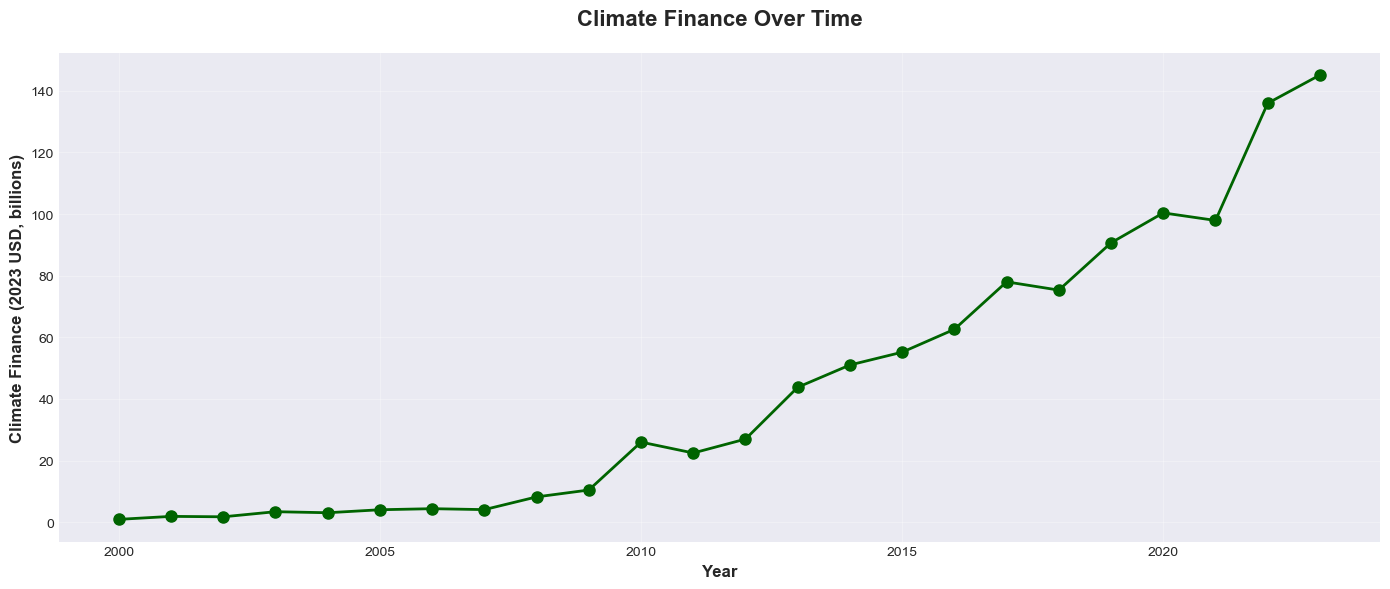


Climate Finance by Year (2023 USD, billions):
Year
2000      0.93
2001      1.90
2002      1.76
2003      3.42
2004      3.08
2005      4.05
2006      4.39
2007      4.09
2008      8.22
2009     10.45
2010     26.00
2011     22.46
2012     26.98
2013     43.79
2014     51.02
2015     55.17
2016     62.59
2017     78.00
2018     75.31
2019     90.66
2020    100.37
2021     97.92
2022    135.94
2023    145.11
Name: Climate-related development finance - Commitment - 2023 USD thousand, dtype: float64


In [4]:
# Clean and prepare the data
# Convert Year to numeric if needed
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')

# Convert climate finance column to numeric
climate_finance_col = 'Climate-related development finance - Commitment - 2023 USD thousand'
df[climate_finance_col] = pd.to_numeric(df[climate_finance_col], errors='coerce')

# Aggregate by year
finance_by_year = df.groupby('Year')[climate_finance_col].sum().sort_index()

# Create line chart
plt.figure(figsize=(14, 6))
plt.plot(finance_by_year.index, finance_by_year.values / 1e6, marker='o', linewidth=2, markersize=8, color='darkgreen')
plt.title('Climate Finance Over Time', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Year', fontsize=12, fontweight='bold')
plt.ylabel('Climate Finance (2023 USD, billions)', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nClimate Finance by Year (2023 USD, billions):")
print((finance_by_year / 1e6).round(2))

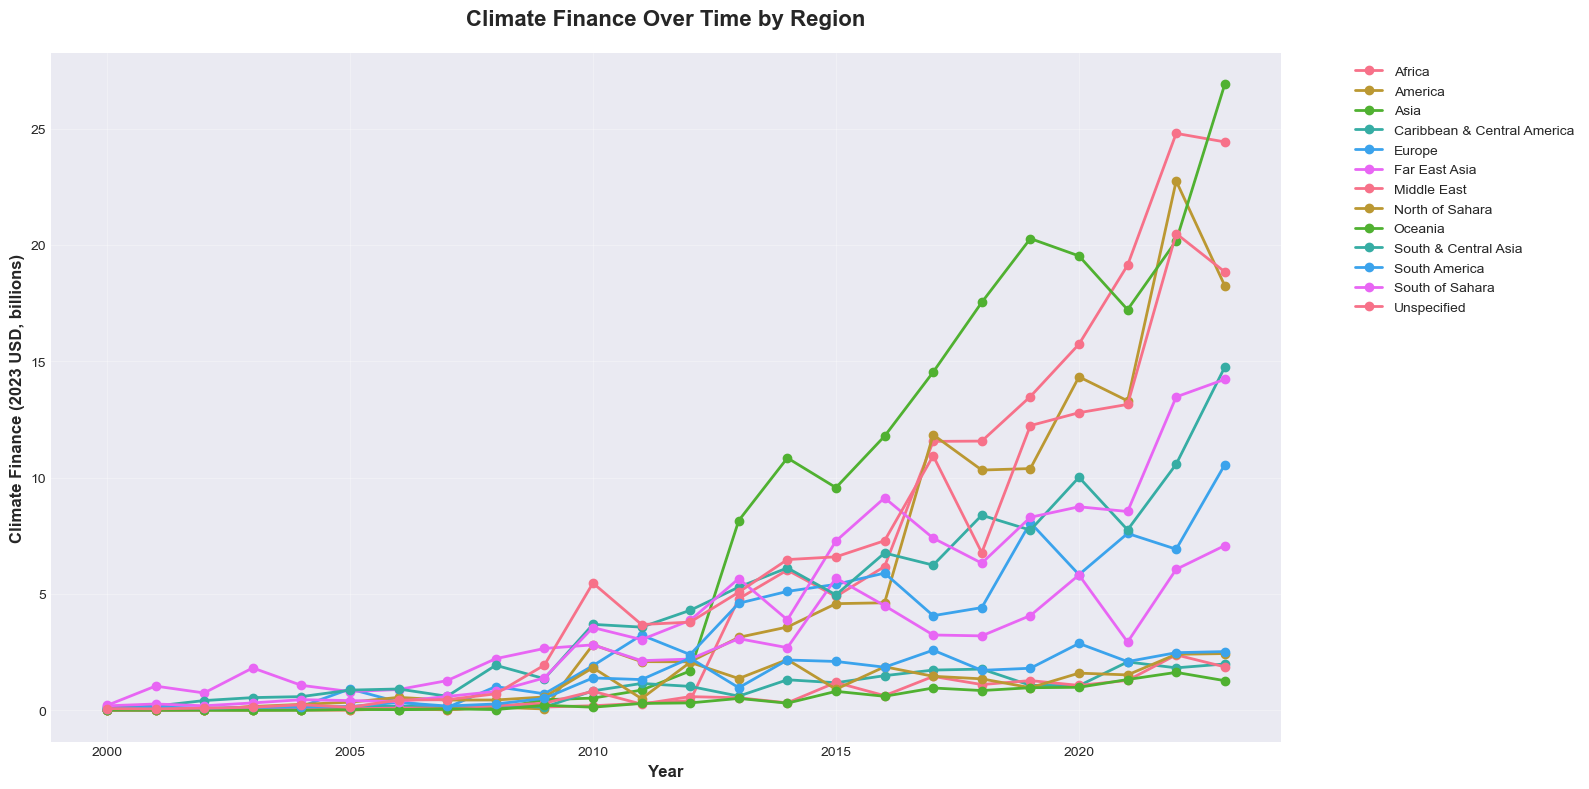

In [5]:
# Optional: Breakdown by Region
if 'Recipient Region' in df.columns:
    finance_by_year_region = df.groupby(['Year', 'Recipient Region'])[climate_finance_col].sum().reset_index()
    
    plt.figure(figsize=(16, 8))
    for region in finance_by_year_region['Recipient Region'].unique():
        region_data = finance_by_year_region[finance_by_year_region['Recipient Region'] == region]
        plt.plot(region_data['Year'], region_data[climate_finance_col] / 1e6, 
                marker='o', linewidth=2, label=region, markersize=6)
    
    plt.title('Climate Finance Over Time by Region', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Year', fontsize=12, fontweight='bold')
    plt.ylabel('Climate Finance (2023 USD, billions)', fontsize=12, fontweight='bold')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

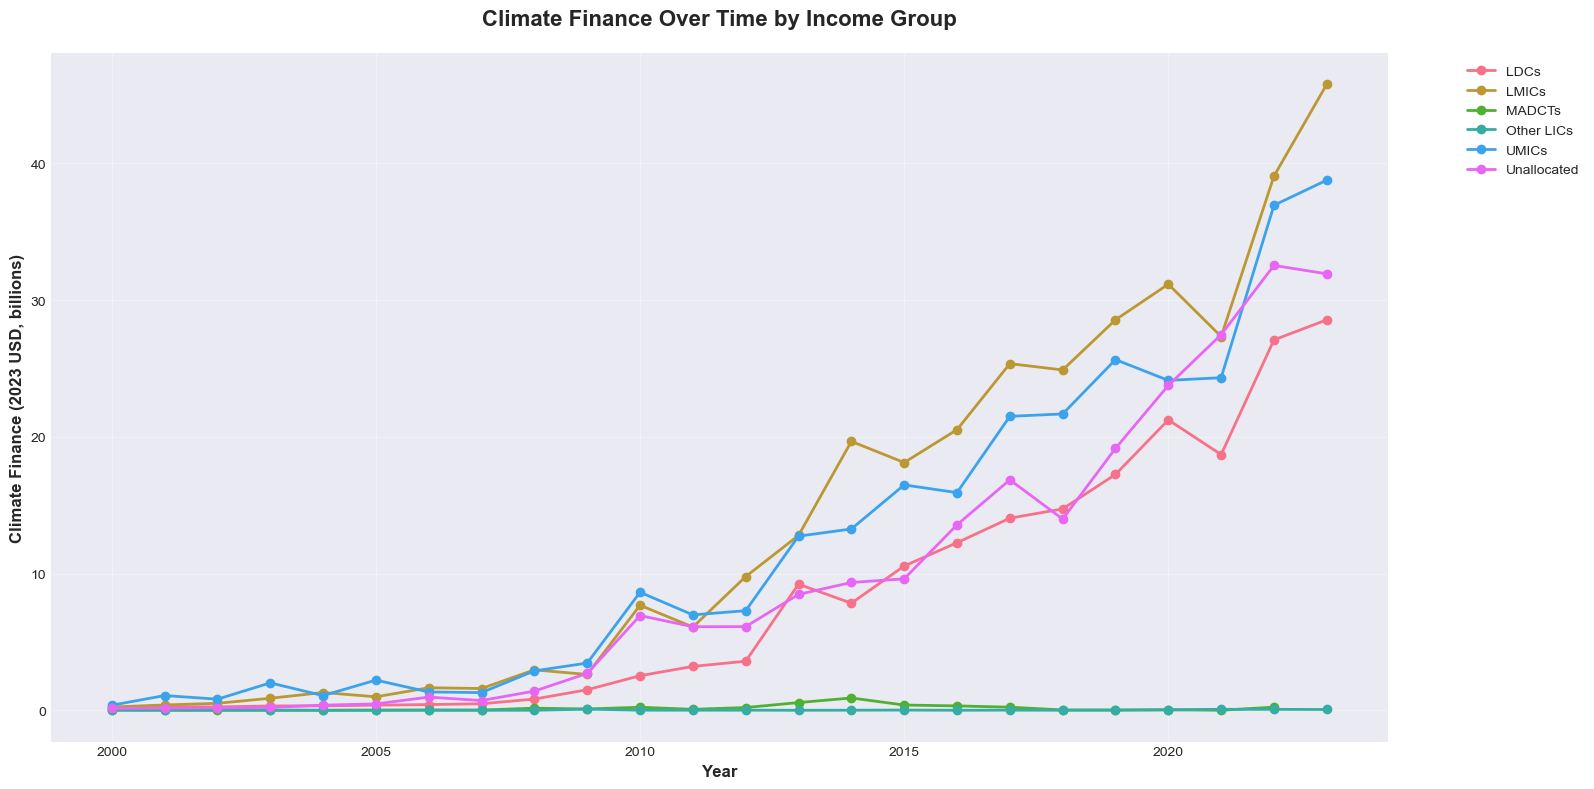

In [6]:
# Optional: Breakdown by Income Group
if 'Recipient Income Group (OECD Classification)' in df.columns:
    finance_by_year_income = df.groupby(['Year', 'Recipient Income Group (OECD Classification)'])[climate_finance_col].sum().reset_index()
    
    plt.figure(figsize=(16, 8))
    for income in finance_by_year_income['Recipient Income Group (OECD Classification)'].unique():
        income_data = finance_by_year_income[finance_by_year_income['Recipient Income Group (OECD Classification)'] == income]
        plt.plot(income_data['Year'], income_data[climate_finance_col] / 1e6, 
                marker='o', linewidth=2, label=income, markersize=6)
    
    plt.title('Climate Finance Over Time by Income Group', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Year', fontsize=12, fontweight='bold')
    plt.ylabel('Climate Finance (2023 USD, billions)', fontsize=12, fontweight='bold')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## 2. Top Recipient Countries (Distribution)

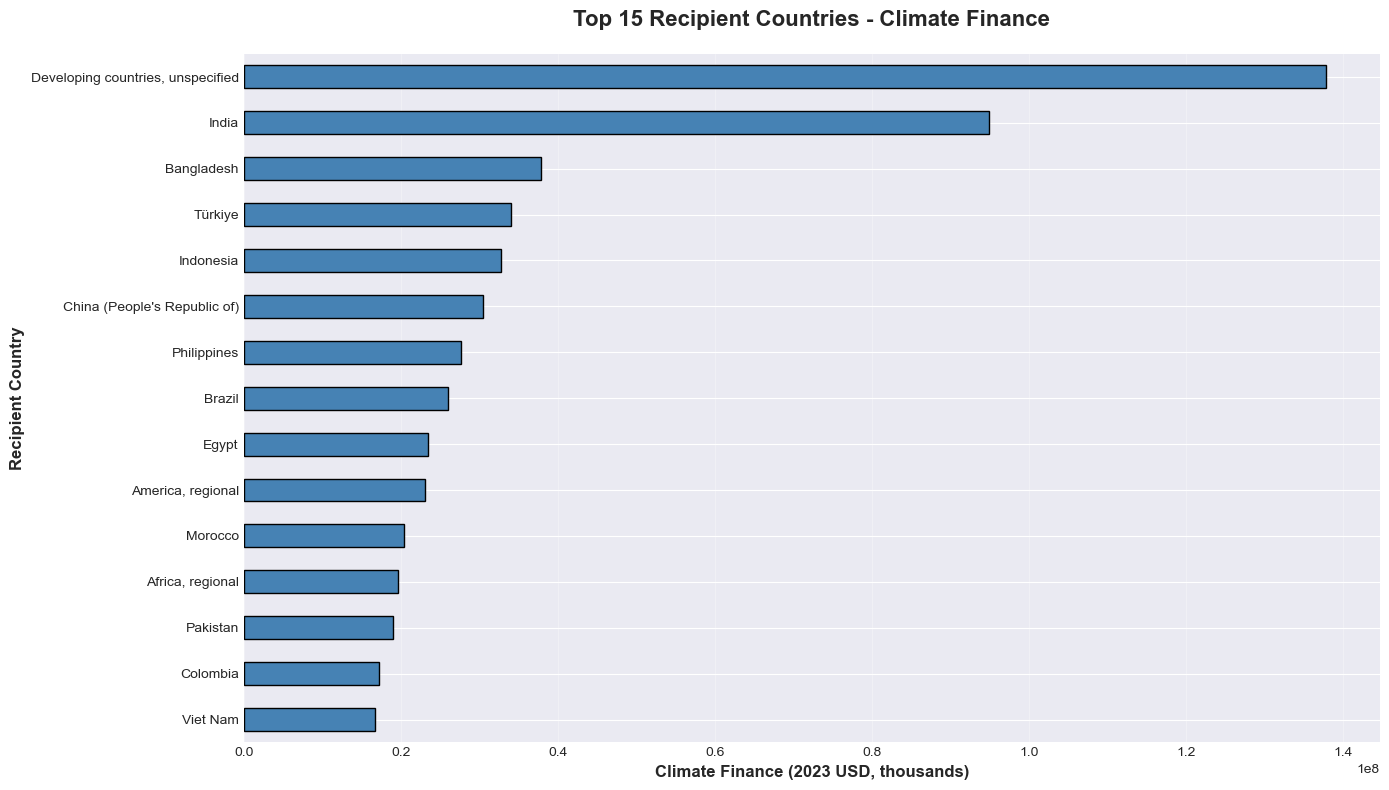


Top 15 Recipient Countries:
Recipient
Developing countries, unspecified    137.86
India                                 94.98
Bangladesh                            37.85
Türkiye                               34.00
Indonesia                             32.83
China (People's Republic of)          30.50
Philippines                           27.74
Brazil                                26.07
Egypt                                 23.44
America, regional                     23.16
Morocco                               20.49
Africa, regional                      19.71
Pakistan                              19.05
Colombia                              17.24
Viet Nam                              16.73
Name: Climate-related development finance - Commitment - 2023 USD thousand, dtype: float64


In [7]:
# Aggregate by recipient country
if 'Recipient' in df.columns:
    finance_by_recipient = df.groupby('Recipient')[climate_finance_col].sum().sort_values(ascending=False)
    
    # Get top 15 countries
    top_recipients = finance_by_recipient.head(15)
    
    # Create bar chart
    plt.figure(figsize=(14, 8))
    top_recipients.plot(kind='barh', color='steelblue', edgecolor='black')
    plt.title('Top 15 Recipient Countries - Climate Finance', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Climate Finance (2023 USD, thousands)', fontsize=12, fontweight='bold')
    plt.ylabel('Recipient Country', fontsize=12, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"\nTop 15 Recipient Countries:")
    print((top_recipients / 1e6).round(2))

## 3. Finance by Region (Stacked Bar)

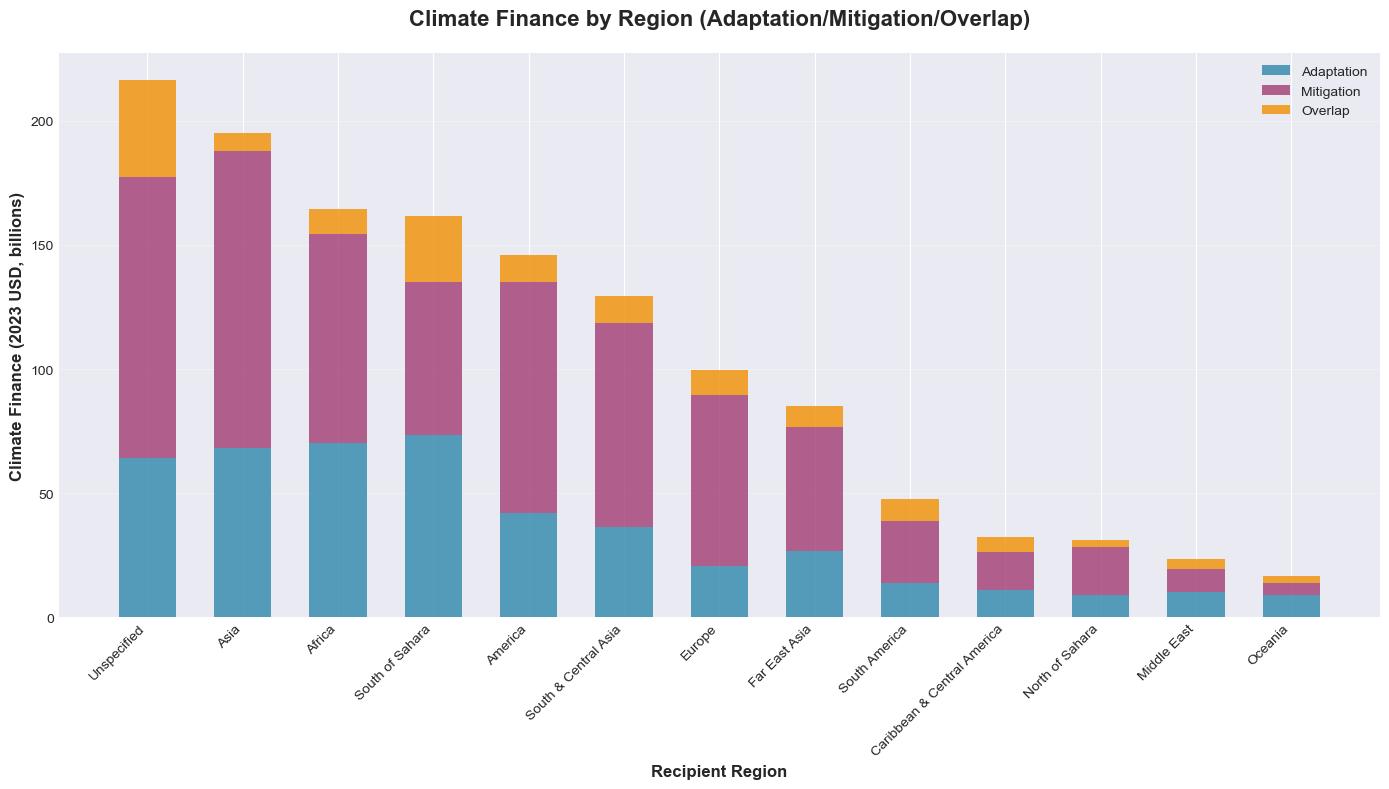


Finance by Region (billions USD):
                             Adaptation-related development finance (includes overlap) - Commitment - 2023 USD thousand  \
Recipient Region                                                                                                          
Unspecified                                                              64.11                                            
Asia                                                                     68.04                                            
Africa                                                                   70.26                                            
South of Sahara                                                          73.40                                            
America                                                                  42.01                                            
South & Central Asia                                                     36.34                          

In [8]:
# Prepare data for stacked bar chart
adaptation_col = 'Adaptation-related development finance (includes overlap) - Commitment - 2023 USD thousand'
mitigation_col = 'Mitigation-related development finance (includes overlap) - Commitment - 2023 USD thousand'
overlap_col = 'Overlap - Commitment - 2023 USD thousand'

# Convert to numeric
df[adaptation_col] = pd.to_numeric(df[adaptation_col], errors='coerce')
df[mitigation_col] = pd.to_numeric(df[mitigation_col], errors='coerce')
df[overlap_col] = pd.to_numeric(df[overlap_col], errors='coerce')

if 'Recipient Region' in df.columns:
    # Aggregate by region
    region_finance = df.groupby('Recipient Region').agg({
        adaptation_col: 'sum',
        mitigation_col: 'sum',
        overlap_col: 'sum'
    })
    region_finance['Total'] = region_finance[adaptation_col] + region_finance[mitigation_col] + region_finance[overlap_col]
    region_finance = region_finance.sort_values('Total', ascending=False)
    
    # Create stacked bar chart
    fig, ax = plt.subplots(figsize=(14, 8))
    
    x = range(len(region_finance))
    width = 0.6
    
    # Plot stacked bars
    p1 = ax.bar(x, region_finance[adaptation_col] / 1e6, width, label='Adaptation', color='#2E86AB', alpha=0.8)
    p2 = ax.bar(x, region_finance[mitigation_col] / 1e6, width, 
                bottom=region_finance[adaptation_col] / 1e6, label='Mitigation', color='#A23B72', alpha=0.8)
    p3 = ax.bar(x, region_finance[overlap_col] / 1e6, width,
                bottom=(region_finance[adaptation_col] + region_finance[mitigation_col]) / 1e6, 
                label='Overlap', color='#F18F01', alpha=0.8)
    
    ax.set_xlabel('Recipient Region', fontsize=12, fontweight='bold')
    ax.set_ylabel('Climate Finance (2023 USD, billions)', fontsize=12, fontweight='bold')
    ax.set_title('Climate Finance by Region (Adaptation/Mitigation/Overlap)', fontsize=16, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(region_finance.index, rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("\nFinance by Region (billions USD):")
    print((region_finance[[adaptation_col, mitigation_col, overlap_col]] / 1e6).round(2))

## 4. Adaptation vs Mitigation Balance

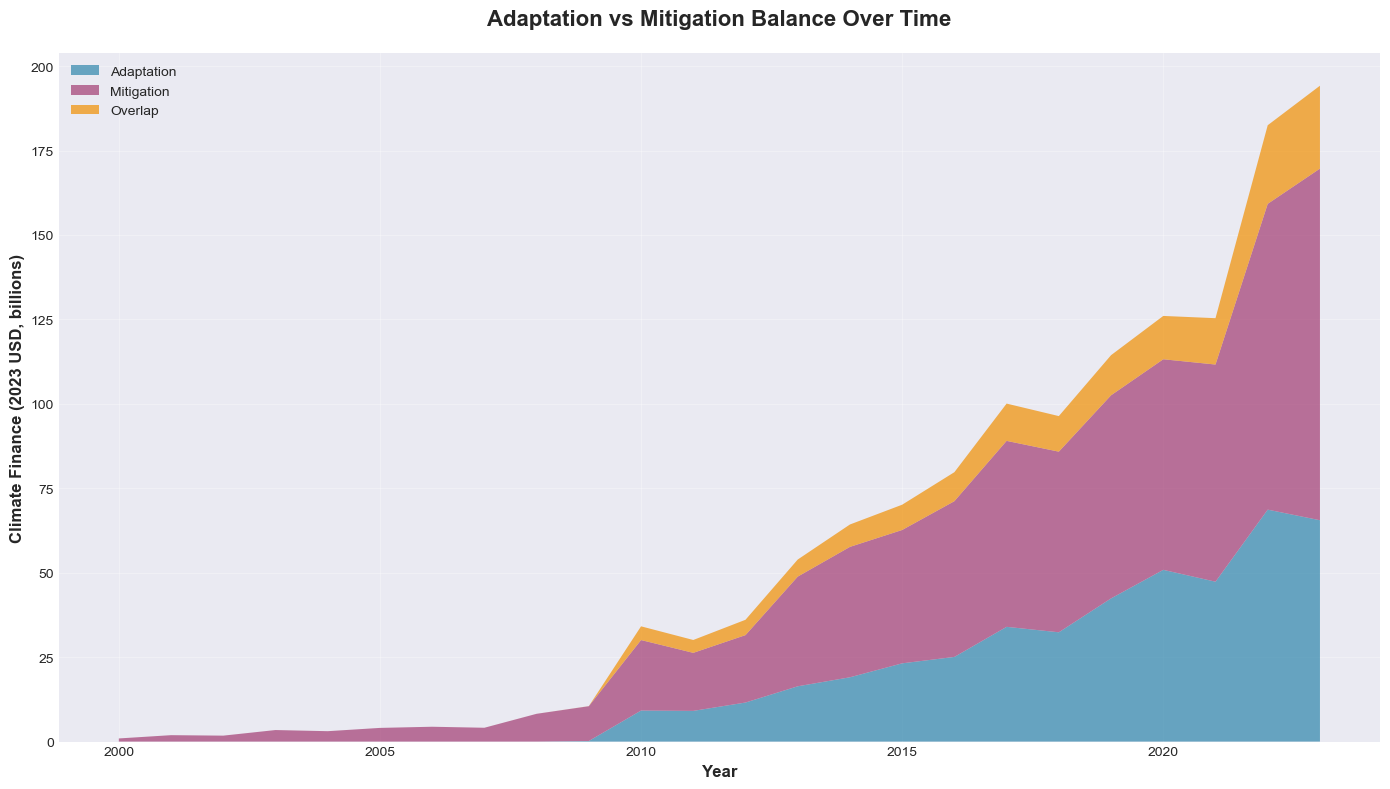

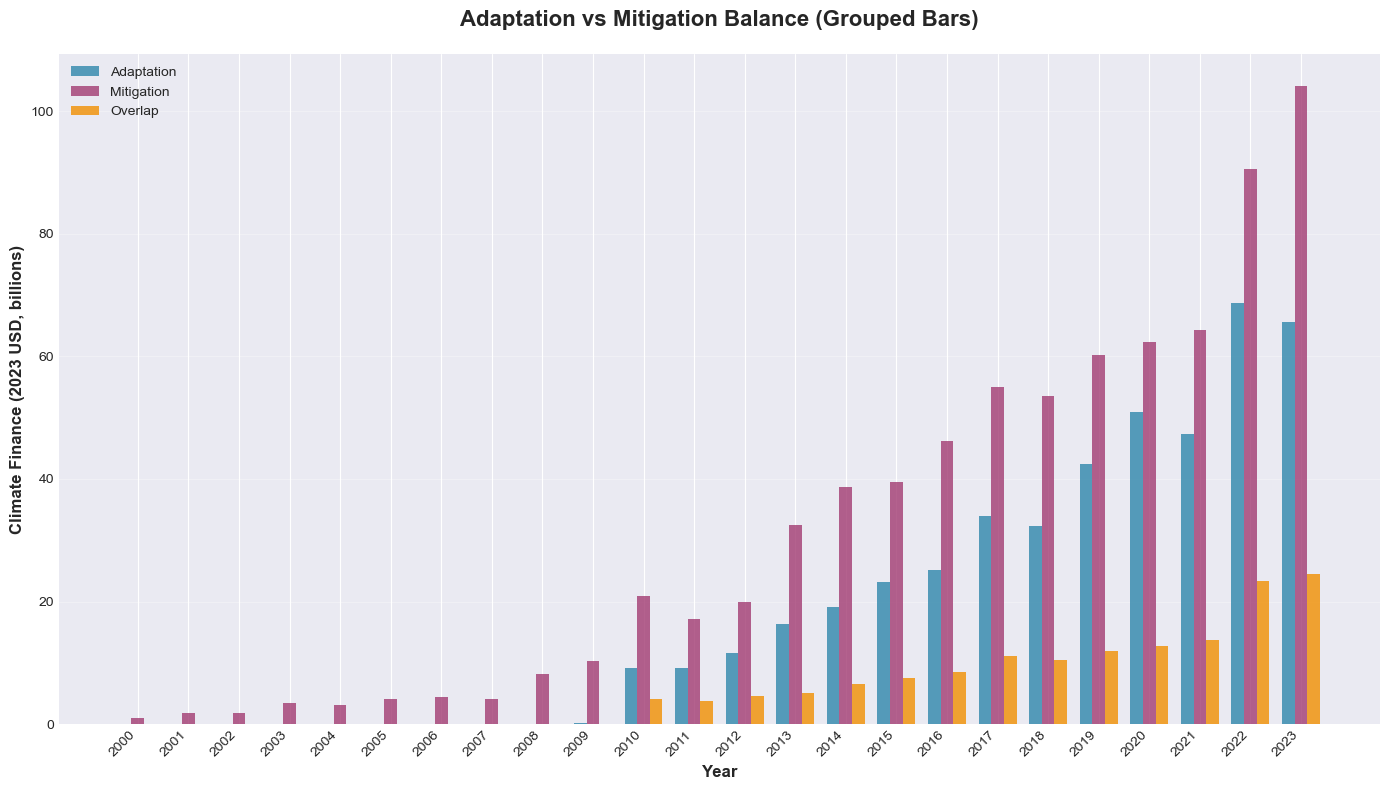

In [9]:
# Aggregate by year
yearly_balance = df.groupby('Year').agg({
    adaptation_col: 'sum',
    mitigation_col: 'sum',
    overlap_col: 'sum'
}).sort_index()

# Create stacked area chart
plt.figure(figsize=(14, 8))
plt.stackplot(yearly_balance.index, 
              yearly_balance[adaptation_col] / 1e6,
              yearly_balance[mitigation_col] / 1e6,
              yearly_balance[overlap_col] / 1e6,
              labels=['Adaptation', 'Mitigation', 'Overlap'],
              colors=['#2E86AB', '#A23B72', '#F18F01'],
              alpha=0.7)

plt.title('Adaptation vs Mitigation Balance Over Time', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Year', fontsize=12, fontweight='bold')
plt.ylabel('Climate Finance (2023 USD, billions)', fontsize=12, fontweight='bold')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Also create grouped bar chart
fig, ax = plt.subplots(figsize=(14, 8))
x = np.arange(len(yearly_balance))
width = 0.25

ax.bar(x - width, yearly_balance[adaptation_col] / 1e6, width, label='Adaptation', color='#2E86AB', alpha=0.8)
ax.bar(x, yearly_balance[mitigation_col] / 1e6, width, label='Mitigation', color='#A23B72', alpha=0.8)
ax.bar(x + width, yearly_balance[overlap_col] / 1e6, width, label='Overlap', color='#F18F01', alpha=0.8)

ax.set_xlabel('Year', fontsize=12, fontweight='bold')
ax.set_ylabel('Climate Finance (2023 USD, billions)', fontsize=12, fontweight='bold')
ax.set_title('Adaptation vs Mitigation Balance (Grouped Bars)', fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(yearly_balance.index, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Distribution by Income Group (Equity)

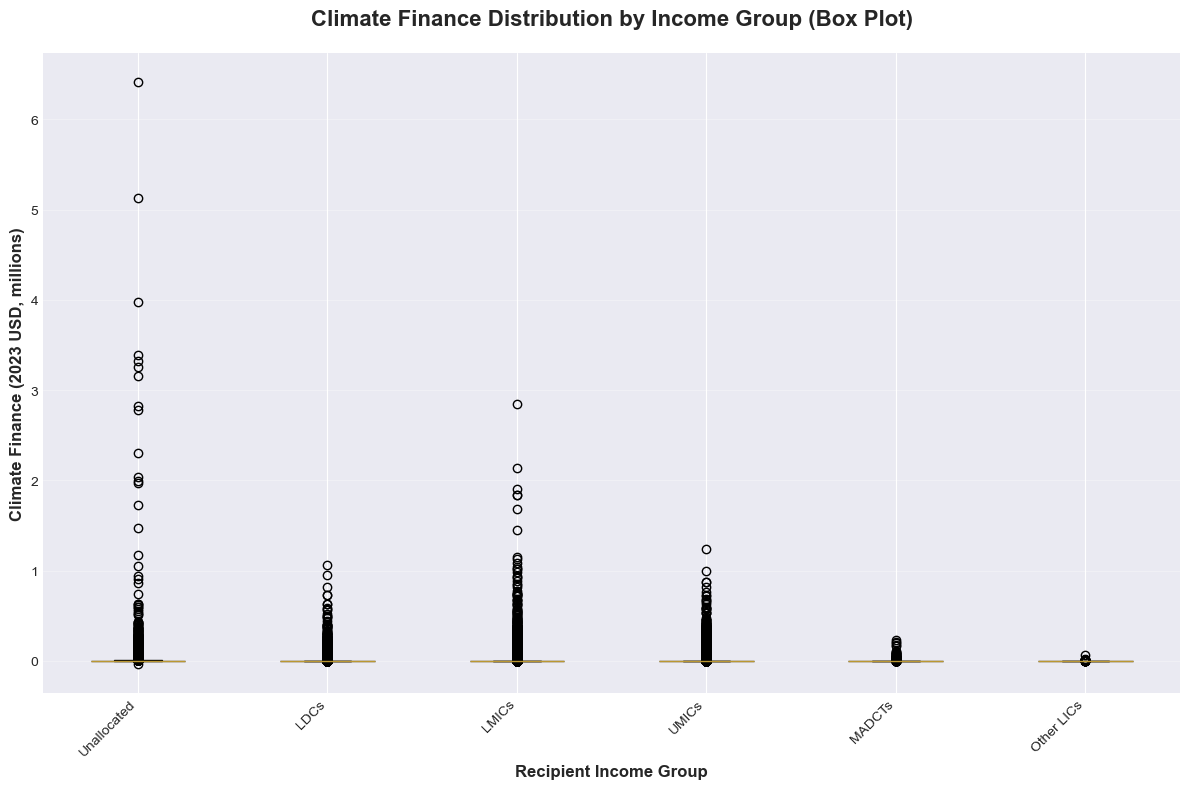

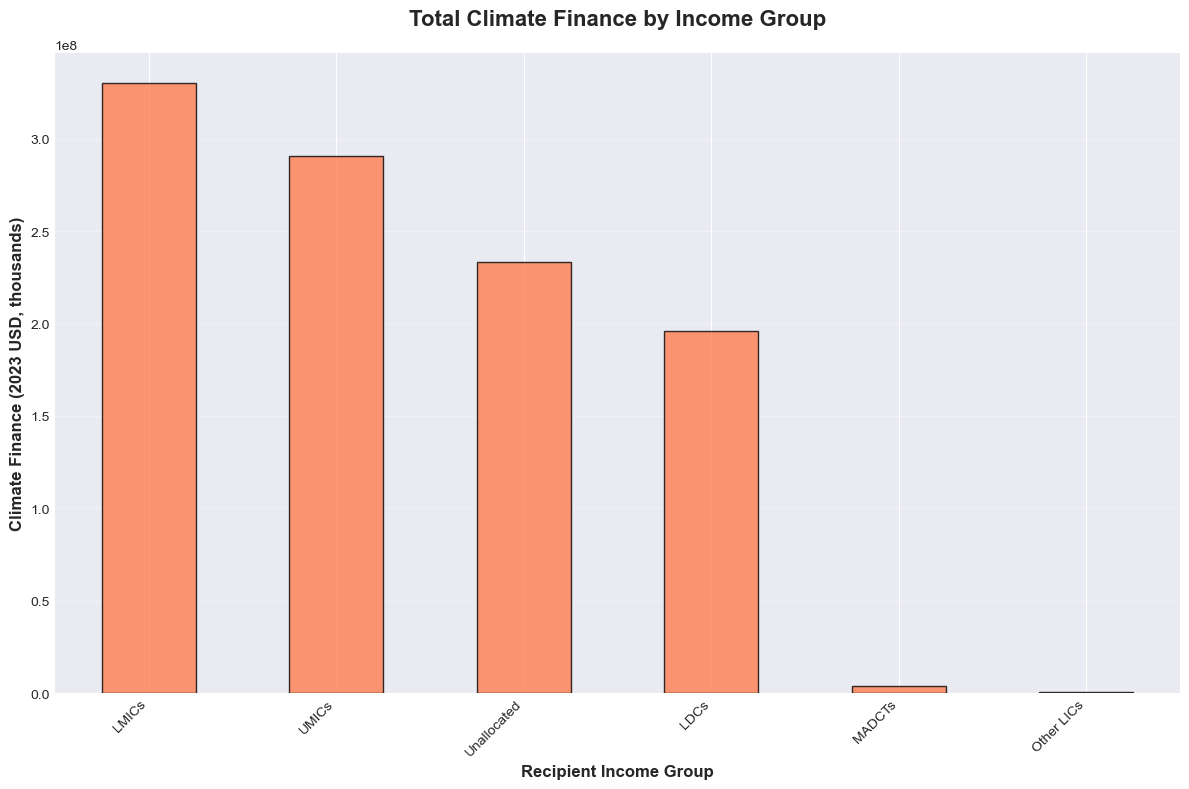


Total Finance by Income Group:
Recipient Income Group (OECD Classification)
LMICs          329.96
UMICs          290.81
Unallocated    233.17
LDCs           195.72
MADCTs           3.55
Other LICs       0.41
Name: Climate-related development finance - Commitment - 2023 USD thousand, dtype: float64


In [10]:
if 'Recipient Income Group (OECD Classification)' in df.columns:
    # Box plot
    income_data = df[df[climate_finance_col].notna() & df['Recipient Income Group (OECD Classification)'].notna()]
    
    plt.figure(figsize=(12, 8))
    income_groups = income_data['Recipient Income Group (OECD Classification)'].unique()
    data_to_plot = [income_data[income_data['Recipient Income Group (OECD Classification)'] == group][climate_finance_col].dropna() / 1e6 
                    for group in income_groups]
    
    bp = plt.boxplot(data_to_plot, labels=income_groups, patch_artist=True)
    for patch in bp['boxes']:
        patch.set_facecolor('lightblue')
        patch.set_alpha(0.7)
    
    plt.title('Climate Finance Distribution by Income Group (Box Plot)', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Recipient Income Group', fontsize=12, fontweight='bold')
    plt.ylabel('Climate Finance (2023 USD, millions)', fontsize=12, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Bar chart (aggregated totals)
    income_totals = df.groupby('Recipient Income Group (OECD Classification)')[climate_finance_col].sum().sort_values(ascending=False)
    
    plt.figure(figsize=(12, 8))
    income_totals.plot(kind='bar', color='coral', edgecolor='black', alpha=0.8)
    plt.title('Total Climate Finance by Income Group', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Recipient Income Group', fontsize=12, fontweight='bold')
    plt.ylabel('Climate Finance (2023 USD, thousands)', fontsize=12, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("\nTotal Finance by Income Group:")
    print((income_totals / 1e6).round(2))

## 6. Sector Allocation of Climate Finance

In [ ]:
if 'Sector' in df.columns:
    # Aggregate by sector
    sector_finance = df.groupby('Sector').agg({
        adaptation_col: 'sum',
        mitigation_col: 'sum'
    })
    sector_finance['Total'] = sector_finance[adaptation_col] + sector_finance[mitigation_col]
    sector_finance = sector_finance.sort_values('Total', ascending=False).head(10)
    
    # Create stacked bar chart
    fig, ax = plt.subplots(figsize=(14, 8))
    
    x = range(len(sector_finance))
    width = 0.6
    
    p1 = ax.bar(x, sector_finance[adaptation_col] / 1e6, width, label='Adaptation', color='#2E86AB', alpha=0.8)
    p2 = ax.bar(x, sector_finance[mitigation_col] / 1e6, width, 
                bottom=sector_finance[adaptation_col] / 1e6, label='Mitigation', color='#A23B72', alpha=0.8)
    
    ax.set_xlabel('Sector', fontsize=12, fontweight='bold')
    ax.set_ylabel('Climate Finance (2023 USD, billions)', fontsize=12, fontweight='bold')
    ax.set_title('Top 10 Sectors - Climate Finance Allocation', fontsize=16, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(sector_finance.index, rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("\nTop 10 Sectors (billions USD):")
    print((sector_finance[[adaptation_col, mitigation_col]] / 1e6).round(2))

## 7. Provider → Recipient Network (Flows)

In [ ]:
# For Sankey diagram, we'll use plotly if available, otherwise create a simplified version
try:
    import plotly.graph_objects as go
    
    # Get top providers and recipients
    if 'Provider (detailed)' in df.columns and 'Recipient' in df.columns:
        # Aggregate flows
        flows = df.groupby(['Provider (detailed)', 'Recipient'])[climate_finance_col].sum().reset_index()
        flows = flows[flows[climate_finance_col] > 0].sort_values(climate_finance_col, ascending=False).head(50)
        
        # Create node lists
        providers = flows['Provider (detailed)'].unique()
        recipients = flows['Recipient'].unique()
        
        all_nodes = list(providers) + list(recipients)
        node_indices = {node: i for i, node in enumerate(all_nodes)}
        
        # Create source, target, and value lists
        source = [node_indices[p] for p in flows['Provider (detailed)']]
        target = [node_indices[r] for r in flows['Recipient']]
        value = flows[climate_finance_col].tolist()
        
        # Create Sankey diagram
        fig = go.Figure(data=[go.Sankey(
            node=dict(
                pad=15,
                thickness=20,
                line=dict(color="black", width=0.5),
                label=all_nodes
            ),
            link=dict(
                source=source,
                target=target,
                value=value
            )
        )])
        
        fig.update_layout(title_text="Provider → Recipient Climate Finance Flows", font_size=12, height=800)
        fig.show()
        
except ImportError:
    print("Plotly not available. Creating simplified flow visualization...")
    
    # Simplified version: Top provider-recipient pairs
    if 'Provider (detailed)' in df.columns and 'Recipient' in df.columns:
        flows = df.groupby(['Provider (detailed)', 'Recipient'])[climate_finance_col].sum().reset_index()
        top_flows = flows.nlargest(20, climate_finance_col)
        
        plt.figure(figsize=(14, 10))
        y_pos = np.arange(len(top_flows))
        plt.barh(y_pos, top_flows[climate_finance_col] / 1e6)
        plt.yticks(y_pos, [f"{p} → {r}" for p, r in zip(top_flows['Provider (detailed)'], top_flows['Recipient'])])
        plt.xlabel('Climate Finance (2023 USD, billions)', fontsize=12, fontweight='bold')
        plt.title('Top 20 Provider → Recipient Flows', fontsize=16, fontweight='bold', pad=20)
        plt.gca().invert_yaxis()
        plt.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        plt.show()

## 8. Project-Level Impact Proxy

In [ ]:
# A. Funding vs Climate Objective
if 'Climate objective (applies to Rio-marked data only or climate component)' in df.columns:
    climate_obj_data = df[df[climate_finance_col].notna() & df['Climate objective (applies to Rio-marked data only or climate component)'].notna()]
    
    plt.figure(figsize=(12, 8))
    objectives = climate_obj_data['Climate objective (applies to Rio-marked data only or climate component)'].unique()
    data_to_plot = [climate_obj_data[climate_obj_data['Climate objective (applies to Rio-marked data only or climate component)'] == obj][climate_finance_col].dropna() / 1e6 
                    for obj in objectives]
    
    bp = plt.boxplot(data_to_plot, labels=objectives, patch_artist=True)
    for patch in bp['boxes']:
        patch.set_facecolor('lightgreen')
        patch.set_alpha(0.7)
    
    plt.title('Funding vs Climate Objective', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Climate Objective', fontsize=12, fontweight='bold')
    plt.ylabel('Climate Finance (2023 USD, millions)', fontsize=12, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

In [ ]:
# B. Funding vs Adaptation/Mitigation Marker
adaptation_obj_col = 'Adaptation objective (applies to Rio-marked data only)'
mitigation_obj_col = 'Mitigation objective (applies to Rio-marked data only)'

if adaptation_obj_col in df.columns and mitigation_obj_col in df.columns:
    # Create a combined analysis
    obj_data = df[df[climate_finance_col].notna()].copy()
    
    # Aggregate by adaptation and mitigation objectives
    adaptation_totals = obj_data.groupby(adaptation_obj_col)[climate_finance_col].sum()
    mitigation_totals = obj_data.groupby(mitigation_obj_col)[climate_finance_col].sum()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Adaptation objectives
    adaptation_totals.plot(kind='bar', ax=ax1, color='#2E86AB', alpha=0.8, edgecolor='black')
    ax1.set_title('Funding by Adaptation Objective', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Adaptation Objective', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Climate Finance (2023 USD, thousands)', fontsize=11, fontweight='bold')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(axis='y', alpha=0.3)
    
    # Mitigation objectives
    mitigation_totals.plot(kind='bar', ax=ax2, color='#A23B72', alpha=0.8, edgecolor='black')
    ax2.set_title('Funding by Mitigation Objective', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Mitigation Objective', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Climate Finance (2023 USD, thousands)', fontsize=11, fontweight='bold')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 9. Channel of Delivery Analysis

In [ ]:
if 'Channel of Delivery' in df.columns:
    channel_finance = df.groupby('Channel of Delivery')[climate_finance_col].sum().sort_values(ascending=False)
    
    plt.figure(figsize=(14, 8))
    channel_finance.plot(kind='bar', color='purple', edgecolor='black', alpha=0.8)
    plt.title('Climate Finance by Channel of Delivery', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Channel of Delivery', fontsize=12, fontweight='bold')
    plt.ylabel('Climate Finance (2023 USD, thousands)', fontsize=12, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("\nFinance by Channel of Delivery:")
    print((channel_finance / 1e6).round(2))